In [1]:
import torch
import torch_geometric
import pathpyG as pp
import csv

# Code

In [2]:
def HotVis(graph: pp.TemporalGraph, orders: int, iterations: int, delta: int, 
           alpha: torch.Tensor | None = None, initial_positions: torch.Tensor | None = None, force: int = 1) -> torch.Tensor:

    if alpha is None:
        alpha = torch.ones(orders)
    if initial_positions is None:
        initial_positions = torch.rand((graph.N, 2))
        
    mo_model = pp.MultiOrderModel.from_temporal_graph(graph, delta=delta, max_order=orders)
    A = torch.zeros((graph.N, graph.N))

    # iterate over higher orders
    for i in range(orders):
        # get higher order graph
        ho_graph = mo_model.layers[i+1]

        # for edge ((v_0, ..., v_{k-1}), (v_1,...,v_k)) get nodes v_0 and v_k
        nodes_start = ho_graph.data.node_sequence[:, 0][ho_graph.data.edge_index[0]]
        nodes_end = ho_graph.data.node_sequence[:, -1][ho_graph.data.edge_index[1]]
        # stack tensors for later use
        indices = torch.stack((nodes_start, nodes_end), dim=0)
        # get edge weights
        edge_weights = ho_graph['edge_weight']
        # remove duplicates while summing their weights up
        indices, edge_weights = torch_geometric.utils.coalesce(indices, edge_weights)
        # add weights to A
        A[indices[0], indices[1]] += alpha[i] * edge_weights

    positions = initial_positions
    t = 0.1
    dt = dt = t / float(iterations + 1)

    delta = torch.zeros((positions.shape[0], positions.shape[0], positions.shape[1]))
    # the inscrutable (but fast) version

    for _ in pp.tqdm(range(iterations)):
        # matrix of difference between points
        delta = positions[torch.newaxis, :, :] - positions[:, torch.newaxis, :]
        # distance between points
        distance = torch.linalg.norm(delta, dim=-1)
        # enforce minimum distance of 0.01
        torch.clip(distance, 0.01, None, out=distance)
        # calculate displacement of all nodes
        displacement = torch.einsum('ijk,ij->ik', delta,
                                (A * distance / force - force**2 / distance**2))
        # calculate length of displacements
        length = torch.linalg.norm(displacement, dim=-1)
        # enforce minimum length of 0.01
        length = torch.where(length < 0.01, 0.1, length)
        # add temperature
        length_with_temp = torch.clamp(length, max=t)
        # calculate the change of the postionions
        delta_positions = torch.einsum('ij,i->ij', displacement, length_with_temp / length)
        # update positions
        positions += delta_positions
        # cool temperature
        t -= dt

    layout = {}
    for node in graph.nodes:
        layout[node] = positions[graph.mapping.to_idx(node)].tolist()

    return layout, mo_model.layers[1], positions, A

def HotVisSlow(graph: pp.TemporalGraph, orders: int, iterations: int, delta: int, 
           alpha: torch.Tensor | None = None, initial_positions: torch.Tensor | None = None, force: int = 1) -> torch.Tensor:
    
    t = 0.1  
    dt = t / float(iterations + 1)

    if alpha is None:
        alpha = torch.ones(orders)
    if initial_positions is None:
        initial_positions = torch.rand((graph.N, 2))
        
    mo_model = pp.MultiOrderModel.from_temporal_graph(graph, delta=delta, max_order=orders)
    A = torch.zeros((graph.N, graph.N))

    for i in range(orders):
        ho_graph = mo_model.layers[i+1]
        # iterate over edges of higher order graph
        for edge in ho_graph.edges:
            # for edge ((v_0, ..., v_{k-1}), (v_1,...,v_k)) get nodes v_0 and v_k
            # for i == 0, edge has form (v_0, v_1)
            if(i == 0):
                node_start = edge[0]
                node_end = edge[1]
            # for i > 0, edge has form ((v_0, ..., v_{i-1}), (v_1,...,v_i))
            else:
                node_start = edge[0][0]
                node_end = edge[1][-1]

            # get indices of the nodes
            index_node_start = graph.mapping.to_idx(node_start)
            index_node_end = graph.mapping.to_idx(node_end)

            # add to A
            A[index_node_start, index_node_end] += alpha[i] * ho_graph['edge_weight', edge[0], edge[1]]
        
    positions = initial_positions

    # every nodes "movement" or displacement gets describet by an tuple (x, y) 
    displacement = torch.zeros((graph.N, 2))
    for _ in range(iterations):
        # reset displacement
        displacement *= 0
        # loop over rows/nodes
        for i in range(A.shape[0]):
            # difference between this row's node position and all others
            delta = positions - positions[i]
            # distance between the nodes
            distance = torch.sqrt((delta**2).sum(dim=1))
            # enforce minimum distance of 0.01
            distance = torch.where(distance < 0.01, 0.01, distance)
            # calculate displacement of node i
            displacement[i] += (delta/distance.view(-1, 1) * (A[i] * distance**2 / force -  force**2 / distance).view(-1,1)).sum(dim=0)
        # get length of displacement
        length = torch.sqrt((displacement**2).sum(dim=1))
        # enforce minimum length of 0.01
        length = torch.where(length < 0.01, 0.1, length)
        # add temperature
        length_with_temp = torch.clamp(length, max=t)
        # update positions
        positions += displacement / length.view(-1, 1) * length_with_temp.view(-1, 1)
        # cool temperature
        t -= dt

    layout = {}
    for node in graph.nodes:
        layout[node] = positions[graph.mapping.to_idx(node)].tolist()

    return layout, mo_model.layers[1], positions, A 


def barycentre(layout, nodes=None):
    if nodes is None:
        node_positions = torch.tensor(list(layout.values())).to(torch.float64)
    else:
        node_positions = torch.tensor([layout[node] for node in nodes]).to(torch.float64)
    return torch.mean(node_positions, dim=0)

# causal_path_set über temporal_shortest_paths bekommen?
def causal_path_dispersion(data, layout, delta=1):
    if isinstance(data, pp.TemporalGraph):
        paths = get_shortest_paths_as_pathdata(data, delta)
    elif isinstance(data, pp.PathData):
        paths = data
    else:
        return 0
    
    numerator = 0
    for i in range(paths.num_paths):
        path = paths.get_walk(i)
        # get positions of nodes of path
        position_nodes = torch.tensor([layout[node] for node in path])
        # Add the summand of the corresponding path to the counter
        numerator += torch.sum(torch.norm(position_nodes - barycentre(layout, path), dim=1))
    numerator *= len(layout)
    # calculate denominator
    positions = torch.tensor(list(layout.values()))
    denominator = torch.sum(torch.norm( positions - barycentre(layout), dim=1)) * paths.num_paths
    return numerator/denominator

def get_shortest_paths_as_pathdata(graph, delta):
    dist, pred = pp.algorithms.temporal_shortest_paths(graph, delta)
    paths = pp.PathData(graph.mapping)
    for node_i in range(graph.N):
           for node_j in range(graph.N):
                if dist[node_i, node_j] > 0 and pred[node_i, node_j] != -1:
                    # initialize path
                    causal_path = [graph.mapping.to_id(node_j)]
                    current_node = node_j

                    # append predecessor\n",
                    while pred[node_i, current_node] != node_i:
                            current_node = pred[node_i, current_node]
                            causal_path.insert(0, graph.mapping.to_id(current_node))

                    # insert starting node
                    causal_path.insert(0, graph.mapping.to_id(node_i))
                    # add path to set of paths
                    paths.append_walk(causal_path)

    return paths
    

def closeness_centrality_paths(paths):
    ret_dict = {v: 0 for v in paths.mapping.node_ids}
    for v in paths.mapping.node_ids:
        for w in paths.mapping.node_ids:
            numerator = 0
            denominator = 0
            if w != v:
                for i in range(paths.num_paths):
                    path = paths.get_walk(i)
                    if v in path and w in path:
                        numerator += 1
                        denominator += abs(path.index(v)-path.index(w))
            if(numerator > 0):                
                ret_dict[v] += numerator/denominator
            else:
                ret_dict[v] += 0
    return ret_dict

def closeness_eccentricity(data, layout, delta, percentile):
    # get closeness centrality of all nodes
    if isinstance(data, pp.TemporalGraph):
        #closeness_centrality = pp.algorithms.centrality.temporal_closeness_centrality(data, delta)
        paths = get_shortest_paths_as_pathdata(data, delta)
        closeness_centrality = closeness_centrality_paths(paths)
    elif isinstance(data, pp.PathData):
        closeness_centrality = closeness_centrality_paths(data)
    else:
        return
    closeness_values = torch.tensor(list(closeness_centrality.values()), dtype=torch.float32)

    # determine treshold for upper percentile
    threshold = torch.quantile(closeness_values, 1 - percentile)
    
    # filter nodes based on treshold
    keys = list(closeness_centrality.keys())
    percentile_keys = [keys[i] for i in torch.where(closeness_values >= threshold)[0]]
    layout_percentile_nodes = torch.tensor([layout[key] for key in percentile_keys])
    
    # determine barycenter
    barycenter_layout = barycentre(layout)
    
    # determine numerator and denominator of formula for closeness_eccentricity
    numerator = torch.sum(torch.norm(layout_percentile_nodes - barycenter_layout, dim=1)) * len(layout)
    all_layout_values = torch.tensor(list(layout.values()))
    denominator = torch.sum(torch.norm(all_layout_values - barycenter_layout, dim=1)) * len(percentile_keys)
    
    return numerator / denominator

def edge_crossing(data, layout):
    # initialize counter
    counter = 0
    if isinstance(data, pp.TemporalGraph):
        # get undirected (since direction doesn't matter) static graph
        static_graph = data.to_static_graph().to_undirected()
    elif isinstance(data, pp.PathData):
        static_graph = pp.MultiOrderModel.from_PathData(data, 1).layers[1]
    else:
        return
    # get edges
    edges = list(static_graph.edges)
    # every edge {'a','b'} is contained two times (as ('a','b') and as ('b','a'))
    # remove second entry, since direction isn't important for edge crossing
    edges = list(set(tuple(sorted(edge)) for edge in edges))
    # for every pair of edges
    for i in range(len(edges)):
        for j in range(i + 1, len(edges)):
            
            # check if the edges intersect (if no two nodes are the same) -> if so, increase counter
            if edges[i][0] not in edges[j] and edges[i][1] not in edges[j] and edge_intersection(layout[edges[i][0]], layout[edges[i][1]],
                            layout[edges[j][0]], layout[edges[j][1]]):
                counter += 1

    return counter

def edge_intersection(A1, A2, B1, B2):
    # formula for intersection is
    # x = det1 * (x3 - x4) - (x1 - x2) * det2 / (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    # y = det1 * (y3 - y4) - (y1 - y2) * det2 / (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    # where
    # det1 = x1 * y2 - y1 * x2
    # det2 = x3 * y4 - y3 * x4

    # get coordinates
    x1, y1 = A1
    x2, y2 = A2
    x3, y3 = B1
    x4, y4 = B2

    # determine denomitator
    denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)

    # check if edges are parallel (denominator = 0)
    if torch.isclose(torch.tensor(float(denominator)), torch.tensor(0.0)):
        return False

    # determine determinants for nummerator
    det1 = x1 * y2 - y1 * x2
    det2 = x3 * y4 - y3 * x4

    # determine intersection of lines going through A1 and A2 resp. B1 and B2
    x = (det1 * (x3 - x4) - (x1 - x2) * det2) / denominator
    y = (det1 * (y3 - y4) - (y1 - y2) * det2) / denominator
    intersection = torch.tensor([x, y])

    # check if intersection is on edges 
    if is_on_segment(A1, intersection, A2) and is_on_segment(B1, intersection, B2):
        return True
    else:
        return False 

# checks if intersectiion q lies on line from p to r
def is_on_segment(p, q, r):
    return (torch.min(torch.tensor([p[0], r[0]])) <= q[0] <= torch.max(torch.tensor([p[0], r[0]]))) and \
           (torch.min(torch.tensor([p[1], r[1]])) <= q[1] <= torch.max(torch.tensor([p[1], r[1]])))




## Berechnung der Verschiebung aller Knoten in der 2. Schleife von HotVis()

Die Verschiebung (`displacement`) wird mithilfe eines Einsum-Produkts berechnet:

```python
displacement = torch.einsum('ijk,ij->ik', delta, 
                            (A * distance / force - force**2 / distance**2))
```

### Definition von (`delta`)

`delta` ist definiert als eine 3D-Matrix der Form:

`delta` = 
\begin{bmatrix}
  \begin{bmatrix}
    \text{pos}[1] - \text{pos}[1] \\
    \text{pos}[2] - \text{pos}[1] \\
    \text{pos}[3] - \text{pos}[1] \\
    \vdots \\
    \text{pos}[n] - \text{pos}[1] \\
  \end{bmatrix}
  & 
  \begin{bmatrix}
    \text{pos}[1] - \text{pos}[2] \\
    \text{pos}[2] - \text{pos}[2] \\
    \text{pos}[3] - \text{pos}[2] \\
    \vdots \\
    \text{pos}[n] - \text{pos}[2] \\
  \end{bmatrix}
  &
  \cdots
  &
  \begin{bmatrix}
    \text{pos}[1] - \text{pos}[n] \\
    \text{pos}[2] - \text{pos}[n] \\
    \text{pos}[3] - \text{pos}[n] \\
    \vdots \\
    \text{pos}[n] - \text{pos}[n] \\
  \end{bmatrix}
\end{bmatrix}

Jeder hier dargestellte Block berechnet sich dabei durch ```positions - positions[i]```

### Form des 3. Parameters

Der Ausdruck

$\text{A} \cdot \frac{\text{distance}}{\text{force}} - \frac{\text{force}^2}{\text{distance}^2}$

ist eine $n \times n$-Matrix.

### Elementweise Multiplikation

Beide Werte aller $j$ Zeilen der $j \times k$-Blöcke ($i$ stück) aus ```delta```, berechnet durch ```positions - positions[i]```, werden mit dem jeweiligen Wert aus ```A[i, j]``` elementweise multipliziert. Danach wird über den Index ```j``` summiert, also über die Zeilen der Blöcke.

## Berechnung der Änderung der Positionen

Die Änderung der Positionen wird berechnet durch:

```python
delta_positions = torch.einsum('ij,ij->ij', displacement, length_with_temp / length)
```

```delta_positions``` ist eine $ n \times 2 $-Matrix. Die $x$- und $y$-Koordinaten jeder Verschiebung werden mit dem entsprechenden Skalar aus der $n \times 1$-Matrix $\frac{\text{length\_with\_temp}}{\text{length}}$ multipliziert.



# Testen der HotVis-Funktion

Laden des Graphen

In [3]:
graph = pp.io.read_csv_temporal_graph('temporal_clusters_real_kregular.tedges', is_undirected = True, timestamp_format='%S')

Eigentliche Funktion

In [4]:
initial_positions = torch.rand((graph.N, 2))
pos_slow = initial_positions.clone()
pos_fast = initial_positions.clone()

layout_slow, graph_slow, pos_slow, A_slow  = HotVisSlow(graph, orders=2, iterations=50000, delta=1, alpha=[1, 1], initial_positions=pos_slow)
layout_fast, graph_fast, pos_fast, A_fast  = HotVis(graph, orders=2, iterations=50000, delta=1, alpha=[1, 1], initial_positions=pos_fast)


100%|██████████| 50000/50000 [00:05<00:00, 9414.81it/s]


Plotte den Graphen

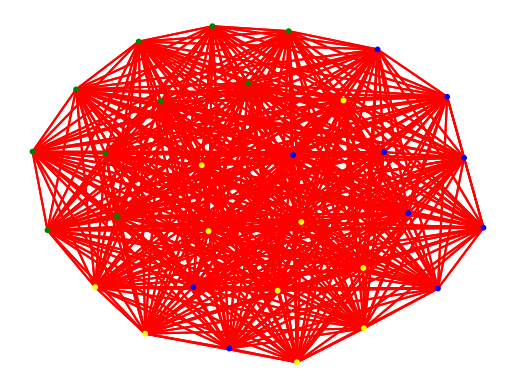

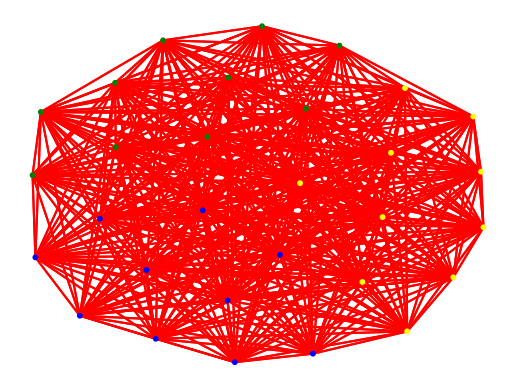

In [5]:
layout_fast = {}
for node in graph.nodes:
    #print(node)
    layout_fast[node] = pos_fast[graph.mapping.to_idx(node)].tolist()
layout_slow = {}
for node in graph.nodes:
    #print(node)
    layout_slow[node] = pos_slow[graph.mapping.to_idx(node)].tolist()

# read colors
colors = {}
with open('colors.csv', mode="r") as file:
    reader = csv.reader(file)
    next(reader)  # Überspringt die Kopfzeile
    for row in reader:
        number, color = row
        colors[number] = color
style = {}
style['node_color'] = colors
style['node_size'] = 10
style['edge_size'] = 0.1

pp.plot(graph.to_static_graph(), layout=layout_fast, backend='matplotlib' ,**style)
pp.plot(graph.to_static_graph(), layout=layout_slow, backend='matplotlib' ,**style)


# Test Metriken

Einfachen Graphen zum Nachrechnen erstellen.

100%|██████████| 6/6 [00:00<00:00, 810.62it/s]

('a', 'b')
('a', 'c')
('a', 'd')
('b', 'a')
('b', 'c')
('b', 'd')
('c', 'b')
('c', 'd')
('d', 'c')
('a', 'b', 'c')
('b', 'a', 'c')
('b', 'a', 'd')
('c', 'b', 'a')
('c', 'b', 'a', 'd')


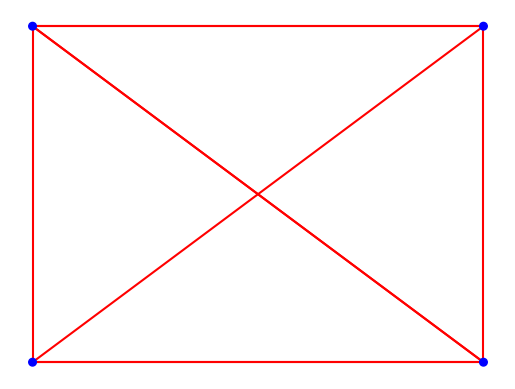

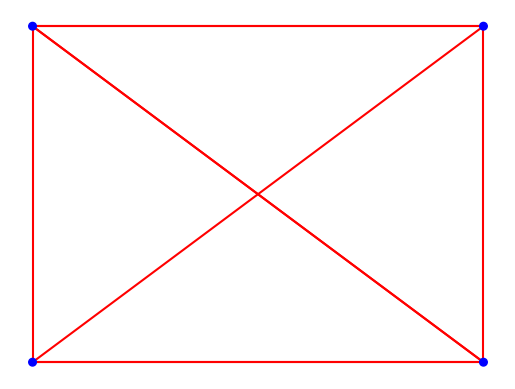

In [6]:
tedges = [('a', 'b', 1),('a', 'b', 2), ('b', 'a', 3), ('b', 'c', 3), ('d', 'c', 4), ('a', 'b', 4), ('c', 'b', 4),
              ('c', 'd', 5), ('b', 'a', 5), ('c', 'b', 6), ('a', 'c', 6), ('b', 'd', 6), ('a', 'd', 6)]
test_graph = pp.TemporalGraph.from_edge_list(tedges)
test_layout= {'a':[0,0], 'b':[1,0], 'c':[0,1], 'd':[1,1]}

# create PathData object with same structure
m = pp.MultiOrderModel.from_temporal_graph(test_graph, 1, 6, cached=True)
test_paths = pp.PathData(test_graph.mapping)

for i in range(2,7):
   for node in list(m.layers[i].nodes):
        if(len(list(node)) == len(set(list(node)))):
                test_paths.append_walk(list(node))

for i in range(test_paths.num_paths):
     print(test_paths.get_walk(i))

pp.plot(test_graph.to_static_graph(), layout=test_layout, backend="matplotlib")

test_m = pp.MultiOrderModel.from_PathData(test_paths, 2, cached=True)
pp.plot(test_m.layers[1], layout=test_layout, backend="matplotlib")

### Barycentre

In [7]:
print(barycentre(test_layout))
print(barycentre(test_layout, ['a']))

tensor([0.5000, 0.5000], dtype=torch.float64)
tensor([0., 0.], dtype=torch.float64)


##### Überprüfung Barycentre

Der Barycenter ist hier $\frac{1}{4} \cdot [0,0] + [1,0] + [0,1] + [1,1] = [0.5, 0.5] $. Damit ist der Wert also richtig.

### Closeness Centrality

In [8]:
print(closeness_centrality_paths(test_paths))

{'a': 2.625, 'b': 2.4571428571428573, 'c': 2.0821428571428573, 'd': 2.2}


##### Überprüfung Closeness Centrality
Die Formel für die Closeness Centrality ist 

$ CC(v) := \sum_{w \neq v \in V} \frac{\sum_{p \in S} \delta_w(p) \delta_v(p)}{\sum_{p \in S, w \in p} \text{dist}(v, w; p)}.$

Zunächst berechnen wir die Closeness Centrality für $a$:
Es gibt folgende Pfade in denen $a$ und $b$ vorkommen:

$(a, b), (b, a), (a, b, c), (b, a, c), (b, a, d), (c, b, a), (c, b, a, d)$

In jedem ist der Pfade ist der Abstand zwischen $a$ und $b$ gleich eins. Damit ergibt sich für den Summand mit $w=b$: $\frac{7}{7}$.
Es gibt folgende Pfade in denen $a$ und $c$ vorkommen:

$(a, c), (a, b, c), (b, a, c), (c, b, a), (c, b, a, d)$

In zwei Fällen ist der Abstand zwischen $a$ und $c$ eins und in drei Fällen zwei. Damit ergibt sich für den Summand mit $w=c$: $\frac{5}{2 \cdot 1 + 3 \cdot 2} = \frac{5}{8}$.
Es gibt folgende Pfade in denen $a$ und $d$ vorkommen:

$(a,d), (b, a, d), (c, b, a, d)$

In allen Fällen ist der Abstand zwischen $a$ und $d$ eins. Damit ergebt sich für den Summand mit $w=d$: $\frac{3}{3}$.
Damit gilt:

$CC(a)=1+\frac{5}{8} + 1 = 2.625$

Analog ergibt sich

$CC(b) = \frac{7}{7}+\frac{6}{7}+\frac{3}{5} = 2.457$

$CC(c) = \frac{5}{8}+\frac{6}{7}+\frac{3}{5} = 2.08$

$CC(d) = \frac{3}{3}+\frac{3}{5}+\frac{3}{5} = 2.2$

### get_shortest_paths_as_pathdata

In [9]:
paths_graph = get_shortest_paths_as_pathdata(test_graph, 1)
for i in range(paths_graph.num_paths):
     print(paths_graph.get_walk(i))

100%|██████████| 6/6 [00:00<00:00, 1487.17it/s]


('a', 'b')
('a', 'c')
('a', 'd')
('b', 'a')
('b', 'c')
('b', 'd')
('c', 'b', 'a')
('c', 'b')
('c', 'd')
('d', 'c')


##### Überprüfung get_shortest_paths_pathdata
Wie sich aus der Liste der Kanten leicht nachvollziehen lässt, gibt es für alle Paare außer $(c,a)$ eine direkte Kante. Für $(c,a)$ gibt es den Causal Path $(a, b, 2), (b, c, 3)$. Somit stimmt das Ergebnis.

### Closeness Eccentricity

In [10]:
print(closeness_centrality_paths(paths_graph))
print(closeness_eccentricity(test_graph, test_layout, percentile=0.1, delta=1))
print(closeness_eccentricity(test_paths, test_layout, percentile=0.1, delta=1))

{'a': 2.6666666666666665, 'b': 3.0, 'c': 2.6666666666666665, 'd': 3.0}


100%|██████████| 6/6 [00:00<00:00, 1373.01it/s]

tensor(1., dtype=torch.float64)
tensor(1., dtype=torch.float64)


##### Überprüfung Closeness Eccentricity
Wir Rechnen den Wert für ```test_paths``` nach. Wir gehen nach der Überprüfung oben davon aus, dass die von ```loseness_centrality_path```zurückgegebenen Werte korrekt sind. Mit der Formel

$\Delta(\gamma) := \frac{\sum_{u_i \in T_{\gamma}} \| Pos[u_i] - B(V) \| \cdot |V|}{|T_{\gamma}| \cdot \sum_{v \in V} \| Pos[v] - B(V) \|} \in [0, 1]$, 

wobei $T_{\gamma}$ die Menge der Knoten mit Closeness Centrality im oberen $\gamma$-Percentile ist, ergibt sich für $\gamma = 0.1$:

$\Delta(0.1) = \frac{(\sqrt{0.5}+ \sqrt{0.5}) \cdot 4}{2 \cdot (\sqrt{0.5}+ \sqrt{0.5}+ \sqrt{0.5}+ \sqrt{0.5})} = 1$.

Damit stimmt der von der Funktion zurückgegebene Wert.

### Causal Path Dispersion

In [11]:
print(causal_path_dispersion(test_graph, test_layout))
print(causal_path_dispersion(test_paths, test_layout))

100%|██████████| 6/6 [00:00<00:00, 1937.62it/s]

tensor(1.7260, dtype=torch.float64)
tensor(2.1132, dtype=torch.float64)


##### Überprüfung Causal Path Dispersion

Wir rechnen die Causal Path Dispersion für ```test_graph```nach, wobei die Pfade auf der sie berechnet wird, den kürzesten Temporal Paths entsprechen. Die Formel für die Causal Path Dispersion ist

$\sigma = \frac{\sum_{p \in S} \sum_{u_i \in p} \left\| Pos[u_i] - B(p) \right\| \cdot |V|}{|S| \cdot \sum_{v_i \in V} \left\| Pos[v_i] - B(V) \right\|} \in [0,1]$.

Für die Pfade ergibt sich folgender Summand im Nenner:

- $(a,b): 1$
- $(a,c): 1$
- $(a,d): \sqrt(2)$
- $(b,a): 1$
- $(b,c): \sqrt(2)$
- $(b,d): 1$
- $(c,b,a): \sqrt{\frac{2}{9}} + 2 \cdot \sqrt{\frac{5}{9}}$
- $(c,b): \sqrt(2)$
- $(c,d): 1$
- $(d,c): 1$

Damit ergibt sich für den Zähler $4 \cdot (6+ 3\cdot \sqrt{2} + \sqrt{\frac{2}{9}} + 2 \cdot \sqrt{\frac{5}{9}}) = 48.82$.

Der Nenner berechnet sich aus $10 \cdot 4 \cdot \sqrt{0.5} = 28.28$

Damit ergibt sich für das Ergebnis $1.72$, was mit dem Ergbenis der Funktion übereinstimmt.





### Edge Crossing

In [12]:
print(edge_crossing(test_graph, test_layout))
print(edge_crossing(test_paths, test_layout))

1
1


##### Überprüfung Edgecrossing
Die Warte lassen sich leicht durch einen Blick auf die Plots der Graphen überprüfen.